In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
from numba import njit,jit
import time
from matplotlib import pyplot as plt
from pytransform3d import rotations as pyro
from matplotlib.image import NonUniformImage
import yaml
import networkx as nx
import matplotlib

In [2]:
# Define run path
path_prefix = Path("/Users/saadjansari/Documents/Projects/Results/AMSOS/Confinement/scan_d_pf_const_num/run")
path_prefix.resolve()
# find all simulations in run path
simpaths = []
simnames = []
for item in path_prefix.glob('*'):
    item.resolve()
    simpaths.append(item)
    simnames.append( item.name)

# packing fractions
pf_labels = []
pf_vals = []
d_labels = []
d_vals = []
for ss in simnames:
    pf = ss.split('_')[0][2:]
    d = ss.split('_')[1][1:]
    pf_labels.append( pf)
    pf_vals.append( float(pf))
    d_labels.append( d)
    d_vals.append( float( d)/10**(len(d)-1))
    
dix = {'simname': simnames, 
       'pf':pf_vals,
      'd':d_vals,
      'pf_labels': pf_labels,
      'd_labels': d_labels,
      'simpath': simpaths}
simdf = pd.DataFrame(dix)

In [3]:
def find_last_seed(spath):
    # Given a series of sim continuations, find the latest one
    # sim continuations look like ['s0', 's0_c', 's0_c_c']. The last one in this case
    # is 's0_c_c'
    
    def num_c(k):
        return len(k.name.split('_c'))
    
    return sorted( spath.glob('*'), key=num_c)[-1]

    
def get_volume_from_config(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    
    if conf:
        cyl_length = box_size[ np.array( rconfig['boundaries'][0]['axis'], dtype=bool)]
        cyl_rad = rconfig['boundaries'][0]['radius']
        vol = math.pi * cyl_rad**2 * cyl_length
        vol = vol[0]
    else:
        vol = boxsize[0]*boxsize[1]*boxsize[2]
    
    return vol

def get_boxsize_pbc(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    if conf:
        box_size[0] = 2*box_size[0]
        box_size[1] = 2*box_size[1]
    return box_size
    
def find_last_n_frames(spath,n=1):
    
    def fileKey(f):
        return int( f.parts[-1].split('_')[-1].split('.dat')[0] )
    file_s_last = sorted( list(spath.glob('**/SylinderAscii*')), key=fileKey)[-n:]
    file_p_last = sorted( list(spath.glob('**/ProteinAscii*')), key=fileKey)[-n:]
    return file_s_last, file_p_last

def read_dat_sylinder( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent)-2, dtype=int)
        rad = np.zeros(len(filecontent)-2)
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        ort = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            gids[idx] = int(data[1])

            dat = np.array( list(map(float,data[2::])) )
            rad[idx] = dat[0]
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]
            xi = pos1[idx,:] - pos0[idx,:]
            ort[idx,:] =  xi/np.sqrt(xi.dot(xi))

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'radius' : rad,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'orientation': list(ort)
        })
    return df

def read_dat_protein( fname):
    # Read a ProetinAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent), dtype=int)
        pos0 = np.zeros( (len(filecontent),3))
        pos1 = np.zeros( (len(filecontent),3))
        link0 = np.zeros( len(filecontent), dtype=int)
        link1 = np.zeros( len(filecontent), dtype=int)

        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            # pdb.set_trace()
            gids[idx] = int(data[1])
            link0[idx] = int(data[9])
            link1[idx] = int(data[10])
            dat = np.array( list(map(float,data[2:9])) )
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'link0': link0,
        'link1': link1
        })
    return df

In [4]:
@njit
def calc_distance_pbc(p0,p1,boxsize):
    # distance between two points in the nearest image convention
    # can use multidimensional arrays for distances between multiple points
    dist = np.absolute( p1-p0)
    for idx in np.arange(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            dist[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            dist[:,idx] -= k*boxsize[idx]
    return np.absolute(dist)

@njit
def calc_mean_pbc(p0,p1,boxsize):
    # mean of the two points in the nearest image
    dist = np.absolute(p1-p0)
    for idx in np.arange(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            p1[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            p1[:,idx] -= k*boxsize[idx]
        # elif len(dist.shape) == 3:
            # k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            # p1[:,:,idx] -= k*boxsize[idx]
    return (p0 + p1)/2

@njit
def unfold_coordinates(crds,c_ref,boxsize):
    # unfolded crds via the nearest image convention

    # reference coordinate
    dist = crds-c_ref
    for idx in np.arange(crds.shape[-1]):
        k = np.sign( dist[:,idx]) * np.floor( np.absolute(dist[:,idx])/(0.51*boxsize[idx]))
        crds[:,idx] -= k*boxsize[idx]
    return crds

def get_edges_in_largest_cc( cc, edge0, edge1):

    # initialize
    idx_edges = []
    n_edges = 0

    # num xlinks in biggest cluster
    for idx in np.arange(len(edge0)):
        if edge0[idx] in cc and edge1[idx] in cc:
            idx_edges.append( idx)
            n_edges+=1

    return idx_edges, n_edges

def get_largest_cc( nodes, edge0, edge1):
    # Get largesst connected component
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc = list( max(nx.connected_components(g), key=len) )

    # also get a boolean array representing nodes that are in the largest cc
    cc_bool = np.zeros(len(nodes), dtype=bool)
    cc_bool[ cc] = True
    return cc, cc_bool

def get_large_clusters( nodes, edge0, edge1, min_size_ratio=0.1):
    # Get large connected components
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc_sort = sorted(nx.connected_components(g), key=len, reverse=True)
    cc_large = [ii for ii in cc_sort if len(ii) > min_size_ratio*len(nodes)]
    return cc_large

@njit
def calc_z_ordering( orient_array):
    # Calculate alignment in z

    if not np.any( orient_array):
        return np.nan

    z_axis = np.array( [0.,0.,1.])
    sum_all = 0
    for idx in np.arange( orient_array.shape[0]):
        sum_all += np.absolute( orient_array[idx,:].dot(z_axis) )
    return sum_all/orient_array.shape[0]

In [14]:
# for each sim, calculate stuff
zorder = []

for idx in np.arange(len( simdf.index)):
    simpath = simdf.simpath[idx]
    
    # Load data
    boxsize = get_boxsize_pbc( find_last_seed(simpath), conf=True)
    
    # get last n frames
    syl_frame = find_last_n_frames( find_last_seed( simpath),n=1)[0][0]
    prot_frame = find_last_n_frames( find_last_seed( simpath),n=1)[1][0]
            
    df_sylinder = read_dat_sylinder( syl_frame )
    df_protein = read_dat_protein( prot_frame)

    # Get large clusters
    cc = get_large_clusters( 
        df_sylinder.gid.tolist(), 
        df_protein.link0.tolist(),
        df_protein.link1.tolist())

    zz = []
    # analyze each cluster
    for clus in cc:
        
        cc_bool = np.zeros(len(df_sylinder.gid.tolist()), dtype=bool)
        cc_bool[ list(clus)] = True
        orts = np.array(df_sylinder[cc_bool].orientation.tolist())
        zz.append( calc_z_ordering(orts))
        
    zorder.append( np.mean(zz))

simdf['zorder'] = zorder

[Text(75.5, 0.5, 'Packing fraction (%)'), Text(0.5, 39.5, 'D/L')]

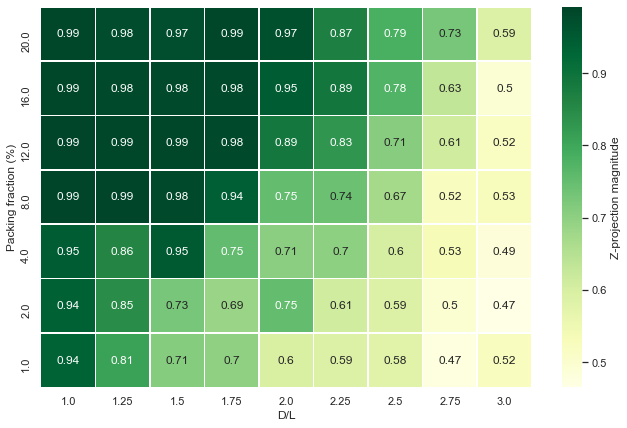

In [17]:
# Create heatmap of z-order

# Get unique values and create an array for storing aspect ratios
upf = np.unique( simdf.pf.tolist())
upflab = list( set(simdf.pf_labels.tolist()))
ud = np.unique( simdf.d.tolist())
udlab = list( set(simdf.d_labels.tolist()))

zz = np.zeros( (len(upf),len(ud)))
for irow in np.arange( len(upf)):
    for icol in np.arange( len(ud)):
        
        pf_lab = pf_labels[ np.argwhere( pf_vals == upf[irow])[0][0] ]
        d_lab = d_labels[ np.argwhere( d_vals == ud[icol])[0][0] ]
        simname = 'pf{0}_d{1}'.format( pf_lab, d_lab)
        idx = simdf.index[ simdf.simname == simname].tolist()[0]
        zz[irow,icol] = simdf.zorder[idx]
        #print('Sim {0} - Aspect ratio = {1}'.format(simname,aspect[irow,icol]))

import seaborn as sns
fig,ax = plt.subplots(figsize=(11,7))
sns.set_theme()
ax = sns.heatmap(zz, linewidths=0.5,annot=True,cmap='YlGn',
                 xticklabels=ud, yticklabels=upf, cbar_kws={'label': 'Z-projection magnitude'})
ax.invert_yaxis()
ax.set(ylabel='Packing fraction (%)', xlabel='D/L')